In [1]:
import torch
import random
import numpy as np
import torchvision.datasets
import matplotlib.pyplot as plt
import pickle
from itertools import product

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
MNIST_train = torchvision.datasets.MNIST('./', train=True)
MNIST_test = torchvision.datasets.MNIST('./', train=False)
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

c:\programdata\miniconda3\lib\site-packages\torchvision\datasets\mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
c:\programdata\miniconda3\lib\site-packages\torchvision\datasets\mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
c:\programdata\miniconda3\lib\site-packages\torchvision\datasets\mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
c:\programdata\miniconda3\lib\site-packages\torchvision\datasets\mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [4]:
X_val = X_train[-5000:]
y_val = y_train[-5000:]

X_train = X_train[:-5000]
y_train = y_train[:-5000]

In [5]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
lenet5 = LeNet5()

In [6]:
resume = False

if resume: 
    with open('adam_results.pkl', 'rb') as f:
        arr = pickle.load(f)
    test_accuracy_history_adam = arr["acc"]
    test_history_adam = arr["loss"]
else:
    test_accuracy_history_adam, test_loss_history_adam = {}, {}

In [7]:
for learning_rate, weight_decay in product([0.1, 0.03, 0.01], [1e-3, 3e-4, 1e-4, 0]):
    
    key = (learning_rate, weight_decay)
    if key in test_accuracy_history_adam:
        print("Already computed, ignoring")
        continue
    
    lenet5 = LeNet5()
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(lenet5.parameters(), lr=learning_rate, weight_decay=weight_decay)
    batch_size = 100

    test_loss_history_adam[key] = list()
    test_accuracy_history_adam[key] = list()

    for epoch in range(20):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
        
            batch_indexes = order[start_index:start_index+batch_size]
        
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]
        
            preds = lenet5.forward(X_batch) 
        
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            
            optimizer.step()
        
        test_preds = lenet5.forward(X_val)
        test_loss_history_adam[key].append(loss(test_preds, y_val).data)
    
        accuracy = (test_preds.argmax(dim=1) == y_val).float().mean().data
        test_accuracy_history_adam[key].append(accuracy)
    
    print(test_accuracy_history_adam[key])
    with open('adam_results.pkl', 'wb') as f:
        pickle.dump({"acc": test_accuracy_history_adam, "loss": test_loss_history_adam}, f)

[tensor(0.0998), tensor(0.0964), tensor(0.1126), tensor(0.0988), tensor(0.1018), tensor(0.1018), tensor(0.0998), tensor(0.0966), tensor(0.0998), tensor(0.0966), tensor(0.0966), tensor(0.1060), tensor(0.0998), tensor(0.3726), tensor(0.3938), tensor(0.1932), tensor(0.4364), tensor(0.6168), tensor(0.2216), tensor(0.3930)]
[tensor(0.0978), tensor(0.1060), tensor(0.0986), tensor(0.1060), tensor(0.0978), tensor(0.0966), tensor(0.0978), tensor(0.0964), tensor(0.0964), tensor(0.0986), tensor(0.0986), tensor(0.0998), tensor(0.1018), tensor(0.0998), tensor(0.1060), tensor(0.0998), tensor(0.1994), tensor(0.1060), tensor(0.2372), tensor(0.0986)]
[tensor(0.2630), tensor(0.2378), tensor(0.2628), tensor(0.1060), tensor(0.0988), tensor(0.0988), tensor(0.0978), tensor(0.0988), tensor(0.0998), tensor(0.1060), tensor(0.0964), tensor(0.0986), tensor(0.1060), tensor(0.0998), tensor(0.0986), tensor(0.1018), tensor(0.0916), tensor(0.0966), tensor(0.1018), tensor(0.0978)]
[tensor(0.4018), tensor(0.3752), tens

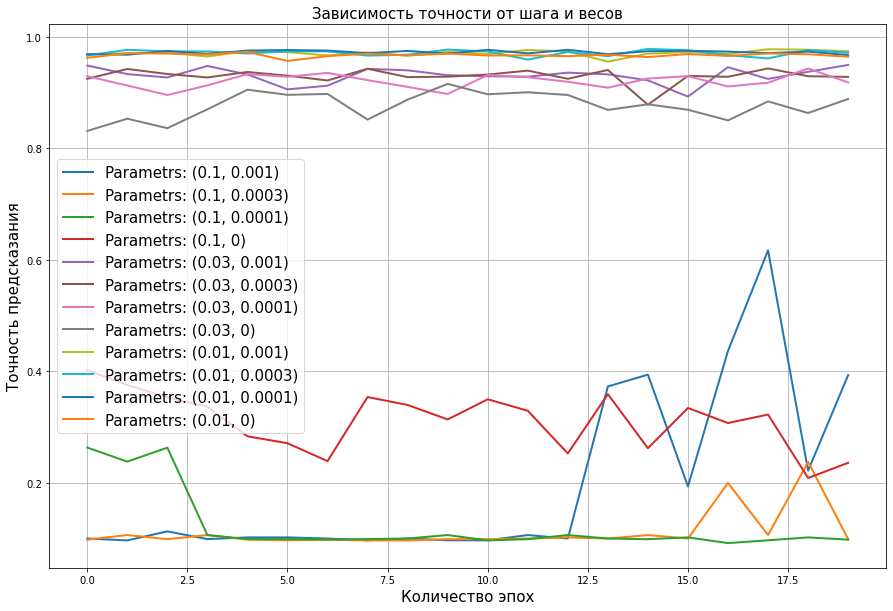

In [8]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и весов', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
for param, accuracy in test_accuracy_history_adam.items():
    plt.plot(accuracy, label = "Parametrs: " + str(param), linewidth=2)
plt.legend(fontsize = 15)
plt.grid(True)

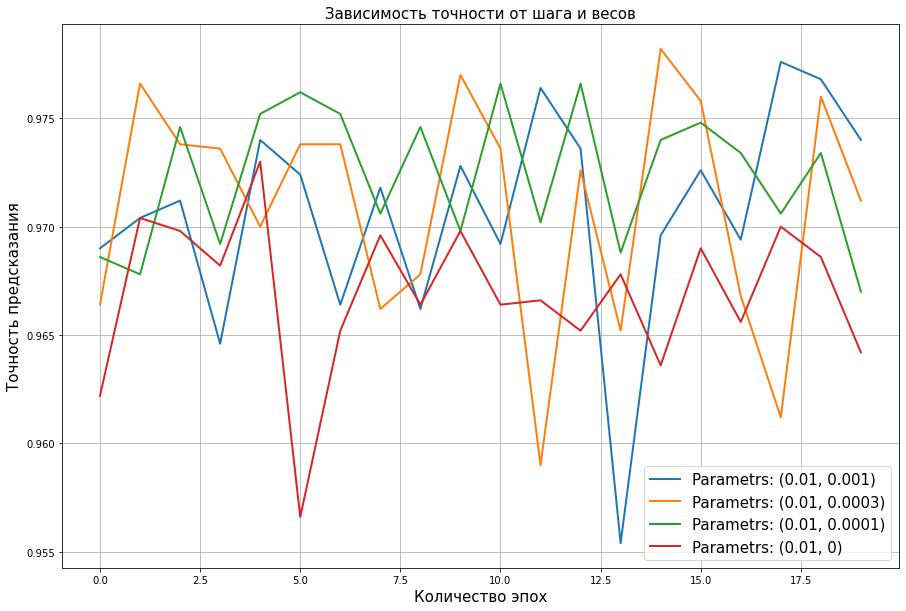

In [9]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и весов', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
for  param in product([0.01], [1e-3, 3e-4, 1e-4, 0]):
    plt.plot(test_accuracy_history_adam[param], label = "Parametrs: " + str(param), linewidth=2)
plt.legend(fontsize = 15)
plt.grid(True)

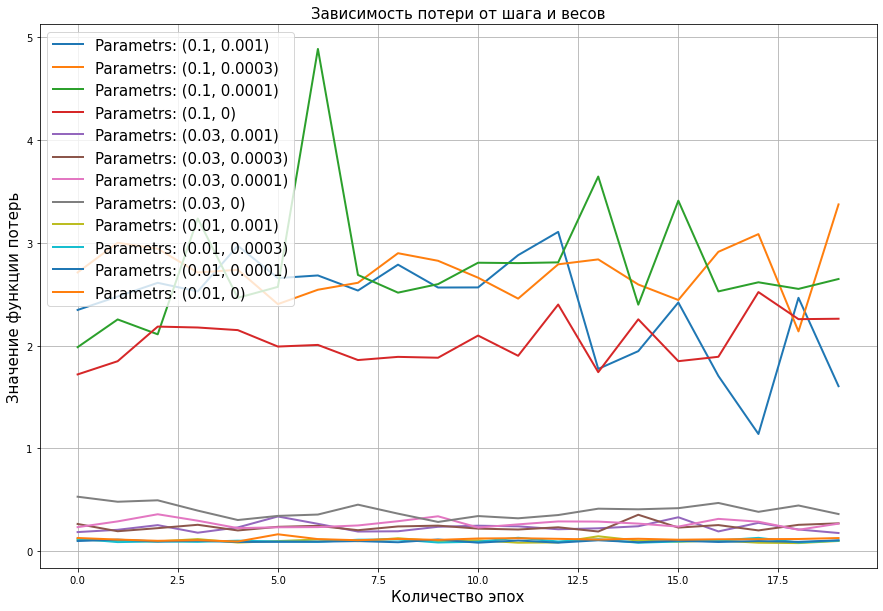

In [10]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и весов', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
for param, loss in test_loss_history_adam.items():
    plt.plot(loss, label = "Parametrs: " + str(param), linewidth=2)
plt.legend(fontsize = 15)
plt.grid(True)

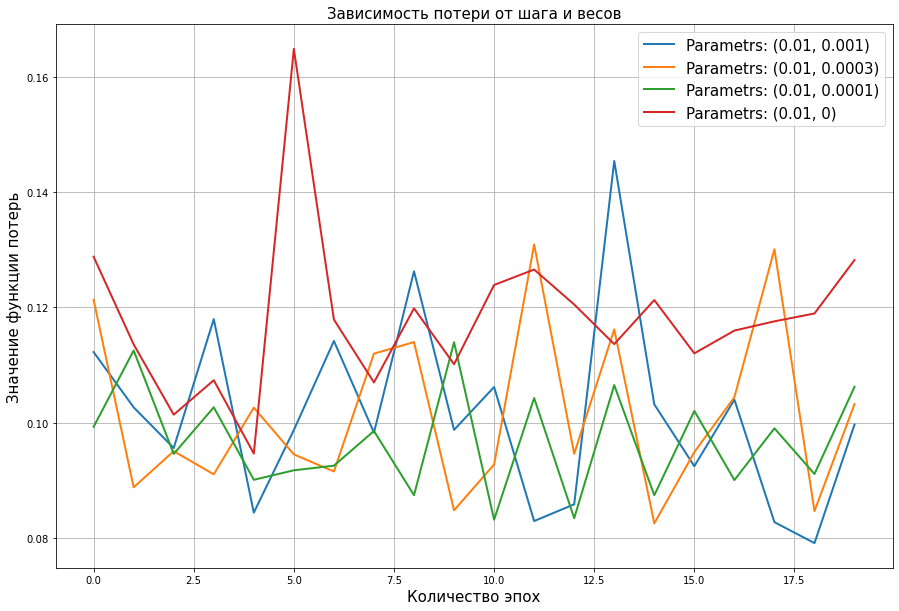

In [11]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и весов', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
for  param in product([0.01], [1e-3, 3e-4, 1e-4, 0]):
    plt.plot(test_loss_history_adam[param], label = "Parametrs: " + str(param), linewidth=2)
plt.legend(fontsize = 15)
plt.grid(True)

In [12]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [14]:
lenet5 = LeNet5()
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=0.01, weight_decay=0.0001)
batch_size = 100

test_loss_history_adam = list()
test_accuracy_history_adam = list()

for epoch in range(20):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = lenet5.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
            
        optimizer.step()
        
    test_preds = lenet5.forward(X_test)
    test_loss_history_adam.append(loss(test_preds, y_test).data)
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data
    test_accuracy_history_adam.append(accuracy)

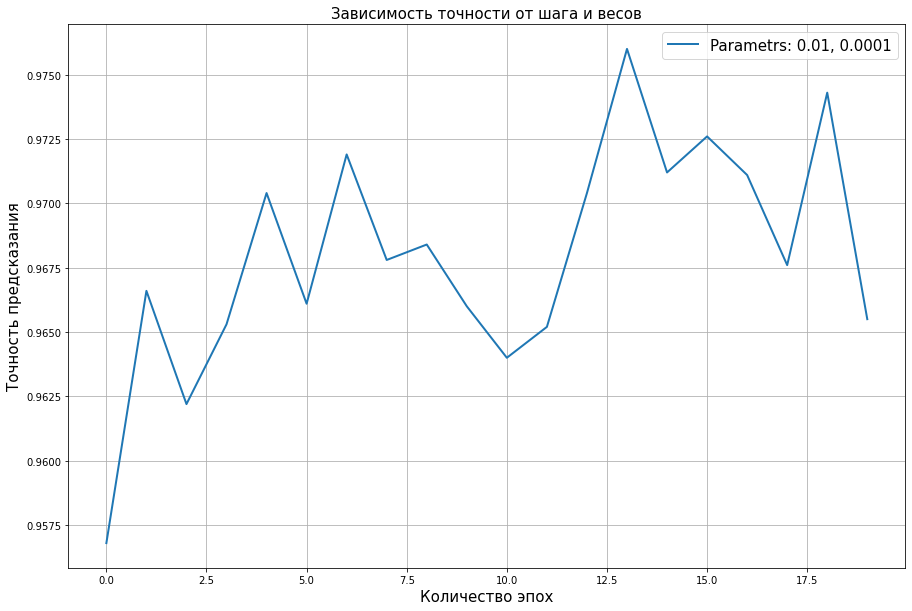

In [15]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость точности от шага и весов', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Точность предсказания', fontsize=15)
plt.plot(test_accuracy_history_adam, label = "Parametrs: 0.01, 0.0001", linewidth=2)
plt.legend(fontsize = 15)
plt.grid(True)

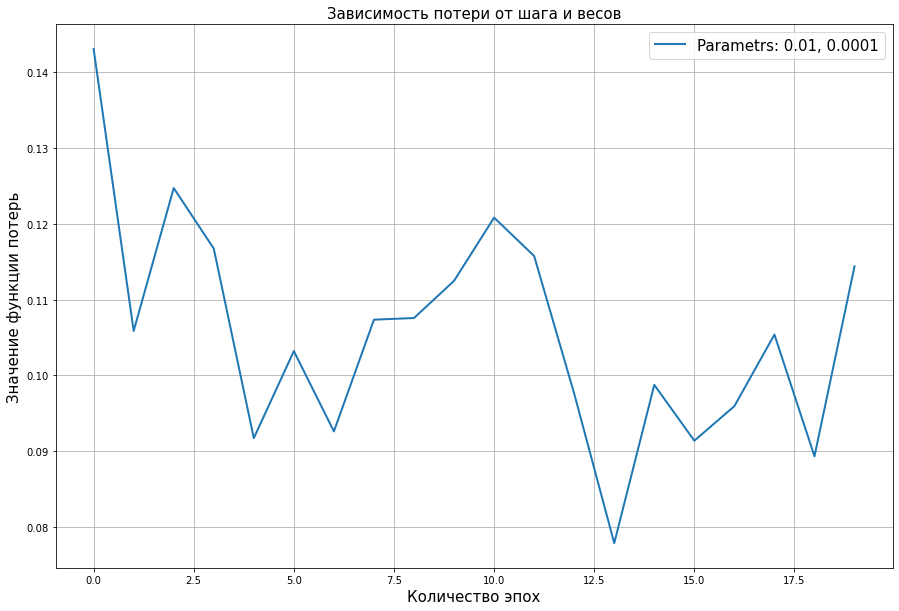

In [16]:
fig = plt.figure(figsize = (15, 10))
plt.title('Зависимость потери от шага и весов', fontsize=15)
plt.xlabel('Количество эпох', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
plt.plot( test_loss_history_adam, label = "Parametrs: 0.01, 0.0001", linewidth=2)
plt.legend(fontsize = 15)
plt.grid(True)

In [17]:
with open('results.pkl', 'wb') as f:
        pickle.dump({"adam_acc": test_accuracy_history_adam, "adam_loss": test_loss_history_adam}, f)